In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from typing import Sequence
from cv2.typing import MatLike

SiftDetectionResult = tuple[Sequence[cv.KeyPoint], MatLike]


def bf_match(des1: MatLike, des2: MatLike) -> MatLike:
    """Optimized brute-force matching with ratio test using matrix operations."""
    # Compute pairwise distances
    distances = np.linalg.norm(des1[:, np.newaxis] - des2, axis=2)
    print(distances.shape)


def showImage(img: MatLike):
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [3]:
img1 = cv.imread('hw1-3-1.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('hw1-3-2.jpg', cv.IMREAD_GRAYSCALE)

In [5]:
sift: cv.SIFT = cv.SIFT_create()

res1: SiftDetectionResult = sift.detectAndCompute(img1, None)
res2: SiftDetectionResult = sift.detectAndCompute(img2, None)
kp1, des1 = res1
kp2, des2 = res2

In [7]:
distances = np.linalg.norm(des1[:, np.newaxis] - des2, axis=2)

In [8]:
sorted_indices = np.argsort(distances, axis=1)
smallest_distances = distances[np.arange(len(des1)), sorted_indices[:, 0]]
second_smallest_distances = distances[np.arange(len(des1)), sorted_indices[:, 1]]

In [13]:
# Apply ratio test
mask = smallest_distances < 0.75 * second_smallest_distances

# Create DMatch objects
matches = [cv.DMatch(i, sorted_indices[i, 0], distances[i, sorted_indices[i, 0]]) for i in np.where(mask)[0]]

# Sort the matches by distance and keep top 20 (or fewer) per object
matches.sort(key=lambda x: x.distance)
matches = matches[:20 * 3]  # Assuming three objects in the image
matches = [[m] for m in matches]

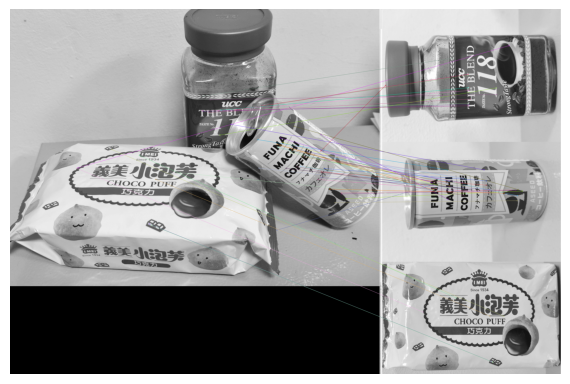

In [14]:

img3 = cv.drawMatchesKnn(
    img1,
    kp1,
    img2,
    kp2,
    matches,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
showImage(img3)